# Pokémon battles — XGBoost with 10-fold outer CV + Grid Search
Notebook breve che esegue: feature engineering, split train/val/test, 10-fold outer CV con GridSearchCV interno, valutazione per fold, valutazione su holdout e generazione submission.csv.

In [20]:
import json
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# --- Percorsi (modificare se necessario) ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
train_file_path = 'train.jsonl'
test_file_path = 'test.jsonl'

def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

print('Caricamento dati...')
train_raw = load_jsonl(train_file_path)
test_raw = load_jsonl(test_file_path)
print(f'Train records: {len(train_raw)}, Test records: {len(test_raw)}')

Caricamento dati...
Train records: 10000, Test records: 5000
Train records: 10000, Test records: 5000


In [21]:
import math
from collections import Counter

# === TYPE CHART (Gen 1) ===
TYPE_CHART = {
    'normal': {'rock': 0.5, 'ghost': 0},
    'fire': {'fire': 0.5, 'water': 0.5, 'grass': 2, 'ice': 2, 'bug': 2, 'rock': 0.5, 'dragon': 0.5},
    'water': {'fire': 2, 'water': 0.5, 'grass': 0.5, 'ground': 2, 'rock': 2, 'dragon': 0.5},
    'grass': {'fire': 0.5, 'water': 2, 'grass': 0.5, 'poison': 0.5, 'ground': 2, 'flying': 0.5, 'bug': 0.5, 'rock': 2, 'dragon': 0.5},
    'electric': {'water': 2, 'grass': 0.5, 'electric': 0.5, 'ground': 0, 'flying': 2, 'dragon': 0.5},
    'ice': {'fire': 0.5, 'water': 0.5, 'grass': 2, 'ground': 2, 'flying': 2, 'dragon': 2},
    'fighting': {'normal': 2, 'ice': 2, 'poison': 0.5, 'flying': 0.5, 'psychic': 0.5, 'bug': 0.5, 'rock': 2, 'ghost': 0},
    'poison': {'grass': 2, 'poison': 0.5, 'ground': 0.5, 'bug': 2, 'rock': 0.5, 'ghost': 0.5},
    'ground': {'fire': 2, 'grass': 0.5, 'electric': 2, 'poison': 2, 'flying': 0, 'bug': 0.5, 'rock': 2},
    'flying': {'grass': 2, 'electric': 0.5, 'fighting': 2, 'bug': 2, 'rock': 0.5},
    'psychic': {'fighting': 2, 'poison': 2, 'psychic': 0.5, 'ghost': 0},
    'bug': {'fire': 0.5, 'grass': 2, 'fighting': 0.5, 'poison': 2, 'flying': 0.5, 'psychic': 2, 'ghost': 0.5},
    'rock': {'fire': 2, 'ice': 2, 'fighting': 0.5, 'ground': 0.5, 'flying': 2, 'bug': 2},
    'ghost': {'normal': 0, 'psychic': 0, 'ghost': 2},
    'dragon': {'dragon': 2}
}

def get_effectiveness(attack_type: str, defense_types: list) -> float:
    if not attack_type or not defense_types:
        return 1.0
    eff = 1.0
    for d in defense_types:
        eff *= TYPE_CHART.get(attack_type, {}).get(d, 1.0)
    return eff

def calculate_type_advantage(team1: list, team2_lead: dict) -> dict:
    out = {'p1_vs_lead_avg_effectiveness': 0.0, 'p1_vs_lead_max_effectiveness': 0.0, 'p1_super_effective_options': 0}
    if not team1 or not team2_lead:
        return out
    lead_types = [t.lower() for t in team2_lead.get('types', [])]
    if not lead_types:
        return out
    effs = []
    for p in team1:
        p_types = [t.lower() for t in p.get('types', [])]
        max_eff = 0.0
        for pt in p_types:
            max_eff = max(max_eff, get_effectiveness(pt, lead_types))
        effs.append(max_eff)
    if not effs:
        return out
    out['p1_vs_lead_avg_effectiveness'] = float(np.mean(effs))
    out['p1_vs_lead_max_effectiveness'] = float(np.max(effs))
    out['p1_super_effective_options'] = int(sum(1 for e in effs if e >= 2))
    return out

def _entropy(counter: Counter) -> float:
    total = sum(counter.values())
    if total == 0:
        return 0.0
    ent = 0.0
    for v in counter.values():
        p = v / total
        if p > 0:
            ent -= p * math.log(p, 2)
    return ent

def team_aggregate_features(team: list, prefix: str = 'p1_') -> dict:
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    out = {}
    vals = {s: [] for s in stats}
    levels = []
    types_counter = Counter()
    names = []
    for p in team:
        names.append(p.get('name',''))
        for s in stats:
            vals[s].append(p.get(s, 0))
        levels.append(p.get('level', 0))
        for t in p.get('types', []):
            types_counter[t.lower()] += 1
    for s in stats:
        arr = np.array(vals[s], dtype=float)
        out[f'{prefix}{s}_sum'] = float(arr.sum())
        out[f'{prefix}{s}_mean'] = float(arr.mean())
        out[f'{prefix}{s}_max'] = float(arr.max())
        out[f'{prefix}{s}_min'] = float(arr.min())
        out[f'{prefix}{s}_std'] = float(arr.std())
    level_arr = np.array(levels, dtype=float)
    out[f'{prefix}level_mean'] = float(level_arr.mean()) if level_arr.size else 0.0
    out[f'{prefix}level_sum'] = float(level_arr.sum()) if level_arr.size else 0.0
    out[f'{prefix}n_unique_types'] = int(len(types_counter))
    common_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying']
    for t in common_types:
        out[f'{prefix}type_{t}_count'] = int(types_counter.get(t, 0))
    out[f'{prefix}lead_name'] = names[0] if names else ''
    out[f'{prefix}n_unique_names'] = int(len(set(names)))
    out[f'{prefix}type_entropy'] = float(_entropy(types_counter))
    spe_arr = np.array(vals['base_spe'], dtype=float)
    out[f'{prefix}spe_p25'] = float(np.percentile(spe_arr, 25)) if spe_arr.size else 0.0
    out[f'{prefix}spe_p50'] = float(np.percentile(spe_arr, 50)) if spe_arr.size else 0.0
    out[f'{prefix}spe_p75'] = float(np.percentile(spe_arr, 75)) if spe_arr.size else 0.0
    return out

def lead_vs_lead_features(p1_lead: dict, p2_lead: dict) -> dict:
    out = {}
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    for s in stats:
        out[f'lead_diff_{s}'] = float(p1_lead.get(s,0) - p2_lead.get(s,0))
    out['lead_speed_advantage'] = float(p1_lead.get('base_spe',0) - p2_lead.get('base_spe',0))
    p1_types = [t.lower() for t in p1_lead.get('types', [])]
    p2_types = [t.lower() for t in p2_lead.get('types', [])]
    max_eff = 0.0
    for pt in p1_types:
        max_eff = max(max_eff, get_effectiveness(pt, p2_types))
    out['lead_p1_vs_p2_effectiveness'] = float(max_eff)
    return out

def lead_aggregate_features(pokemon: dict, prefix: str = 'p2_lead_') -> dict:
    out = {}
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    for s in stats:
        out[f'{prefix}{s}'] = float(pokemon.get(s,0))
    out[f'{prefix}level'] = int(pokemon.get('level',0))
    types = [x.lower() for x in pokemon.get('types', [])]
    common_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying']
    for t in common_types:
        out[f'{prefix}type_{t}'] = int(t in types)
    out[f'{prefix}name'] = pokemon.get('name','')
    out[f'{prefix}n_unique_types'] = int(len(set(types)))
    return out

def summary_from_timeline(timeline: list, p1_team: list) -> dict:
    out = {}
    if not timeline:
        return {'tl_p1_moves':0,'tl_p2_moves':0,'tl_p1_est_damage':0.0,'tl_p2_est_damage':0.0,'damage_diff':0.0}
    p1_moves = p2_moves = 0
    p1_damage = p2_damage = 0.0
    p1_last_active = p2_last_active = ''
    p1_last_hp = p2_last_hp = np.nan
    p1_fainted = p2_fainted = 0
    p1_fainted_names = set()
    p2_fainted_names = set()
    last_p1_hp = {}
    last_p2_hp = {}
    p1_comeback_kos = 0
    p2_comeback_kos = 0
    p1_inflicted_statuses = Counter()
    p2_inflicted_statuses = Counter()
    p1_pokemon_statuses = {}
    p2_pokemon_statuses = {}
    p1_move_type_counts = Counter()
    p2_move_type_counts = Counter()
    p1_damage_first2 = 0.0
    p2_damage_first2 = 0.0

    # NEW: per-turn damage accumulation, KO timing and early/late KO counters
    p1_dmg_by_turn = {}  # damage inflitto da p1 (contro p2) per turno
    p2_dmg_by_turn = {}  # damage inflitto da p2 (contro p1) per turno
    seen_turns = set()
    first_ko_turn_p1_taken = None   # primo KO subìto da p1 (p1_fainted++)
    first_ko_turn_p1_inflicted = None  # primo KO inflitto da p1 (p2_fainted++)
    early_threshold = 10
    p1_kos_early = p1_kos_late = 0
    p2_kos_early = p2_kos_late = 0

    for turn in timeline[:30]:
        prev_p1_fainted, prev_p2_fainted = p1_fainted, p2_fainted
        p1_state = turn.get('p1_pokemon_state',{}) or {}
        p2_state = turn.get('p2_pokemon_state',{}) or {}
        tnum = turn.get('turn', None)
        if tnum is None:
            # fallback: usa lunghezza dei turni visti + 1
            tnum = (len(seen_turns) + 1)
        seen_turns.add(tnum)

        if p1_state.get('name'):
            p1_last_active = p1_state.get('name')
        if p2_state.get('name'):
            p2_last_active = p2_state.get('name')

        if p1_state.get('fainted') and p1_state.get('name') not in p1_fainted_names:
            p1_fainted += 1
            p1_fainted_names.add(p1_state.get('name'))
            if first_ko_turn_p1_taken is None:
                first_ko_turn_p1_taken = tnum
            if tnum <= early_threshold: p2_kos_early += 1
            else: p2_kos_late += 1
        if p2_state.get('fainted') and p2_state.get('name') not in p2_fainted_names:
            p2_fainted += 1
            p2_fainted_names.add(p2_state.get('name'))
            if first_ko_turn_p1_inflicted is None:
                first_ko_turn_p1_inflicted = tnum
            if tnum <= early_threshold: p1_kos_early += 1
            else: p1_kos_late += 1

        p2_name, p2_hp = p2_state.get('name'), p2_state.get('hp_pct')
        if p2_name and p2_hp is not None:
            prev_hp = last_p2_hp.get(p2_name)
            if prev_hp is not None:
                delta = max(0.0, prev_hp - p2_hp)
                p1_damage += delta
                p1_dmg_by_turn[tnum] = p1_dmg_by_turn.get(tnum, 0.0) + delta
                if turn.get('turn',999) <= 2:
                    p1_damage_first2 += delta
            last_p2_hp[p2_name] = p2_hp

        p1_name, p1_hp = p1_state.get('name'), p1_state.get('hp_pct')
        if p1_name and p1_hp is not None:
            prev_hp = last_p1_hp.get(p1_name)
            if prev_hp is not None:
                delta = max(0.0, prev_hp - p1_hp)
                p2_damage += delta
                p2_dmg_by_turn[tnum] = p2_dmg_by_turn.get(tnum, 0.0) + delta
                if turn.get('turn',999) <= 2:
                    p2_damage_first2 += delta
            last_p1_hp[p1_name] = p1_hp

        damage_diff_so_far = p1_damage - p2_damage
        if p2_fainted > prev_p2_fainted and damage_diff_so_far < -1.0:
            p1_comeback_kos += 1
        if p1_fainted > prev_p1_fainted and damage_diff_so_far > 1.0:
            p2_comeback_kos += 1

        p2_status = p2_state.get('status')
        if p2_name and p2_status and p2_pokemon_statuses.get(p2_name) != p2_status:
            p1_inflicted_statuses[p2_status] += 1
            p2_pokemon_statuses[p2_name] = p2_status
        p1_status = p1_state.get('status')
        if p1_name and p1_status and p1_pokemon_statuses.get(p1_name) != p1_status:
            p2_inflicted_statuses[p1_status] += 1
            p1_pokemon_statuses[p1_name] = p1_status

        p1_move = turn.get('p1_move_details') or {}
        p2_move = turn.get('p2_move_details') or {}
        if p1_move and p1_move.get('type'):
            p1_move_type_counts[(p1_move.get('type') or '').lower()] += 1
        if p2_move and p2_move.get('type'):
            p2_move_type_counts[(p2_move.get('type') or '').lower()] += 1
        if turn.get('p1_move_details'):
            p1_moves += 1
        if turn.get('p2_move_details'):
            p2_moves += 1
        p1_last_hp = p1_state.get('hp_pct', np.nan)
        p2_last_hp = p2_state.get('hp_pct', np.nan)

    # ...existing code computing out[...] baseline metrics...
    out['tl_p1_moves'] = int(p1_moves)
    out['tl_p2_moves'] = int(p2_moves)
    out['tl_p1_est_damage'] = float(p1_damage)
    out['tl_p2_est_damage'] = float(p2_damage)
    out['damage_diff'] = float(p1_damage - p2_damage)
    out['fainted_diff'] = int(p1_fainted - p2_fainted)
    out['tl_p1_last_hp'] = float(p1_last_hp) if not np.isnan(p1_last_hp) else 0.0
    out['tl_p2_last_hp'] = float(p2_last_hp) if not np.isnan(p2_last_hp) else 0.0
    out['tl_p1_last_active'] = p1_last_active
    out['tl_p2_last_active'] = p2_last_active
    if p1_team:
        p1_total_hp_sum = sum(p.get('base_hp',0) for p in p1_team)
        p1_avg_def = np.mean([p.get('base_def',0) for p in p1_team] or [0])
        p1_avg_spd = np.mean([p.get('base_spd',0) for p in p1_team] or [0])
        out['tl_p2_damage_vs_p1_hp_pool'] = float(p2_damage / (p1_total_hp_sum + 1e-6))
        out['tl_p1_defensive_endurance'] = float((p1_avg_def + p1_avg_spd) / (p2_damage + 1e-6))
    out['tl_p1_comeback_kos'] = int(p1_comeback_kos)
    out['tl_p2_comeback_kos'] = int(p2_comeback_kos)
    out['tl_comeback_kos_diff'] = int(p1_comeback_kos - p2_comeback_kos)

    common_statuses = ['brn','par','slp','frz','psn','tox']
    for status in common_statuses:
        out[f'tl_p1_inflicted_{status}_count'] = int(p1_inflicted_statuses.get(status,0))
        out[f'tl_p2_inflicted_{status}_count'] = int(p2_inflicted_statuses.get(status,0))
        out[f'tl_inflicted_{status}_diff'] = int(p1_inflicted_statuses.get(status,0) - p2_inflicted_statuses.get(status,0))

    common_move_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying','ghost','bug','poison','fighting']
    for mt in common_move_types:
        out[f'tl_p1_move_type_{mt}_count'] = int(p1_move_type_counts.get(mt,0))
        out[f'tl_p2_move_type_{mt}_count'] = int(p2_move_type_counts.get(mt,0))
        out[f'tl_move_type_{mt}_count_diff'] = int(p1_move_type_counts.get(mt,0) - p2_move_type_counts.get(mt,0))

    out['tl_p1_damage_first2'] = float(p1_damage_first2)
    out['tl_p2_damage_first2'] = float(p2_damage_first2)
    out['tl_first2_damage_diff'] = float(p1_damage_first2 - p2_damage_first2)

    # NEW: derived, normalized and late-game features
    turns_count = max(1, len(seen_turns))
    out['tl_turns_count'] = int(turns_count)
    out['tl_p1_moves_rate'] = float(p1_moves / turns_count)
    out['tl_p2_moves_rate'] = float(p2_moves / turns_count)
    out['tl_p1_damage_per_turn'] = float(p1_damage / turns_count)
    out['tl_p2_damage_per_turn'] = float(p2_damage / turns_count)
    out['tl_damage_rate_diff'] = float(out['tl_p1_damage_per_turn'] - out['tl_p2_damage_per_turn'])

    # last-5-turns damage window
    if seen_turns:
        recent_turns = sorted(seen_turns)[-5:]
        p1_last5 = sum(p1_dmg_by_turn.get(t,0.0) for t in recent_turns)
        p2_last5 = sum(p2_dmg_by_turn.get(t,0.0) for t in recent_turns)
    else:
        p1_last5 = p2_last5 = 0.0
    out['tl_p1_damage_last5'] = float(p1_last5)
    out['tl_p2_damage_last5'] = float(p2_last5)
    out['tl_last5_damage_diff'] = float(p1_last5 - p2_last5)
    # NEW: ratio danno ultimi 5 turni vs totale
    out['tl_p1_last5_damage_ratio'] = float(p1_last5 / (p1_damage + 1e-6))
    out['tl_p2_last5_damage_ratio'] = float(p2_last5 / (p2_damage + 1e-6))
    out['tl_last5_damage_ratio_diff'] = float(out['tl_p1_last5_damage_ratio'] - out['tl_p2_last5_damage_ratio'])

    # time-weighted damage advantage (peso crescente con il turno)
    if seen_turns:
        ts = sorted(seen_turns)
        w = np.linspace(1.0, 2.0, num=len(ts))  # pesi crescenti
        w = w / (w.sum() + 1e-9)
        adv = [(p1_dmg_by_turn.get(t,0.0) - p2_dmg_by_turn.get(t,0.0)) for t in ts]
        out['tl_weighted_damage_diff'] = float(np.dot(w, adv))
    else:
        out['tl_weighted_damage_diff'] = 0.0

    # NEW: comeback indicator (cambio di segno dell'adv cumulativo)
    if seen_turns:
        ts = sorted(seen_turns)
        cum = 0.0
        signs = []
        for t in ts:
            cum += (p1_dmg_by_turn.get(t,0.0) - p2_dmg_by_turn.get(t,0.0))
            s = 1 if cum > 1e-9 else (-1 if cum < -1e-9 else 0)
            if s != 0:
                if not signs or signs[-1] != s:
                    signs.append(s)
        sign_flips = max(0, len(signs) - 1)
        comeback_flag = 1 if (len(signs) >= 2 and signs[0] != signs[-1]) else 0
    else:
        sign_flips = 0
        comeback_flag = 0
    out['tl_damage_adv_sign_flips'] = int(sign_flips)
    out['tl_comeback_flag'] = int(comeback_flag)

    # KO timing and early/late counts
    out['tl_first_ko_turn_p1_inflicted'] = int(first_ko_turn_p1_inflicted or 0)
    out['tl_first_ko_turn_p1_taken'] = int(first_ko_turn_p1_taken or 0)
    out['tl_first_ko_turn_diff'] = int((first_ko_turn_p1_inflicted or 0) - (first_ko_turn_p1_taken or 0))
    out['tl_kos_early_p1'] = int(p1_kos_early)
    out['tl_kos_late_p1'] = int(p1_kos_late)
    out['tl_kos_early_p2'] = int(p2_kos_early)
    out['tl_kos_late_p2'] = int(p2_kos_late)

    # normalized status rates per turn
    for status in common_statuses:
        c1 = p1_inflicted_statuses.get(status,0)
        c2 = p2_inflicted_statuses.get(status,0)
        out[f'tl_p1_inflicted_{status}_rate'] = float(c1 / turns_count)
        out[f'tl_p2_inflicted_{status}_rate'] = float(c2 / turns_count)
        out[f'tl_inflicted_{status}_rate_diff'] = float((c1 - c2) / turns_count)

    return out

def ability_features(team: list, prefix: str) -> dict:
    immunity_abilities = {'levitate':0,'volt_absorb':0,'water_absorb':0,'flash_fire':0}
    stat_drop_abilities = {'intimidate':0}
    weather_abilities = {'drought':0,'drizzle':0,'sand_stream':0}
    out = {}
    for pokemon in team:
        ability = (pokemon.get('ability','') or '').lower().replace(' ','_')
        if ability in immunity_abilities:
            immunity_abilities[ability] += 1
        if ability in stat_drop_abilities:
            stat_drop_abilities[ability] += 1
        if ability in weather_abilities:
            weather_abilities[ability] += 1
    for ability,count in immunity_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    for ability,count in stat_drop_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    for ability,count in weather_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    out[f'{prefix}total_immunity_abilities'] = int(sum(immunity_abilities.values()))
    out[f'{prefix}total_stat_drop_abilities'] = int(sum(stat_drop_abilities.values()))
    return out

def prepare_record_features(record: dict, max_turns: int = 30) -> dict:
    out = {}
    out['battle_id'] = record.get('battle_id')
    if 'player_won' in record:
        out['player_won'] = int(bool(record.get('player_won')))
    p1_team = record.get('p1_team_details', [])
    out.update(team_aggregate_features(p1_team, prefix='p1_'))
    p2_lead = record.get('p2_lead_details', {})
    out.update(lead_aggregate_features(p2_lead, prefix='p2_lead_'))
    out.update(ability_features(p1_team, prefix='p1_'))
    p1_lead = p1_team[0] if p1_team else {}
    out.update(lead_vs_lead_features(p1_lead, p2_lead))
    out.update(ability_features([p2_lead], prefix='p2_lead_'))
    out['p1_intimidate_vs_lead'] = 1 if out.get('p1_ability_intimidate_count',0) > 0 else 0
    tl = record.get('battle_timeline', [])
    out.update(summary_from_timeline(tl[:max_turns], p1_team))
    out['team_hp_sum_minus_p2lead_hp'] = out.get('p1_base_hp_sum', 0) - out.get('p2_lead_base_hp', 0)
    out['team_spa_mean_minus_p2spa'] = out.get('p1_base_spa_mean', 0) - out.get('p2_lead_base_spa', 0)
    out['speed_advantage'] = out.get('p1_base_spe_sum', 0) - out.get('p2_lead_base_spe', 0)
    out['n_unique_types_diff'] = out.get('p1_n_unique_types', 0) - out.get('p2_lead_n_unique_types', 1)
    p1_moves = max(out.get('tl_p1_moves',1),1)
    p2_moves = max(out.get('tl_p2_moves',1),1)
    out['damage_per_turn_diff'] = (out.get('tl_p1_est_damage',0.0)/p1_moves) - (out.get('tl_p2_est_damage',0.0)/p2_moves)
    out['last_pair'] = f"{out.get('tl_p1_last_active','')}_VS_{out.get('tl_p2_last_active','')}"
    out.update(calculate_type_advantage(p1_team, p2_lead))
    p2_lead_bulk = out.get('p2_lead_base_def',1) + out.get('p2_lead_base_spd',1)
    out['p1_se_options_vs_lead_bulk'] = out.get('p1_super_effective_options',0) / (p2_lead_bulk + 1e-6)
    p2_team = record.get('p2_team_details', [])
    if p2_team:
        out.update(team_aggregate_features(p2_team, prefix='p2_'))
        out['team_hp_sum_diff'] = out.get('p1_base_hp_sum',0) - out.get('p2_base_hp_sum',0)
        out['team_spa_mean_diff'] = out.get('p1_base_spa_mean',0) - out.get('p2_base_spa_mean',0)
        out['team_spe_mean_diff'] = out.get('p1_base_spe_mean',0) - out.get('p2_base_spe_mean',0)
        out['n_unique_types_team_diff'] = out.get('p1_n_unique_types',0) - out.get('p2_n_unique_types',0)
    return out

def create_features_from_raw(data: list) -> pd.DataFrame:
    rows = []
    for b in tqdm(data, desc='FE'):
        try:
            feat = prepare_record_features(b, max_turns=30)
            if 'battle_id' not in feat:
                feat['battle_id'] = b.get('battle_id')
            rows.append(feat)
        except Exception as e:
            rows.append({'battle_id': b.get('battle_id'), 'error': 1})
    df = pd.DataFrame(rows)
    if 'player_won' in df.columns:
        df['player_won'] = df['player_won'].astype(int)
    return df.fillna(0)

train_df = create_features_from_raw(train_raw)
test_df = create_features_from_raw(test_raw)
print('Feature shape train/test:', train_df.shape, test_df.shape)
display(train_df.head())

FE: 100%|██████████| 10000/10000 [00:05<00:00, 1966.30it/s]

FE: 100%|██████████| 5000/5000 [00:02<00:00, 1889.75it/s]



Feature shape train/test: (10000, 232) (5000, 231)


,battle_id,player_won,p1_base_hp_sum,p1_base_hp_mean,p1_base_hp_max,p1_base_hp_min,p1_base_hp_std,p1_base_atk_sum,p1_base_atk_mean,p1_base_atk_max,...,team_hp_sum_minus_p2lead_hp,team_spa_mean_minus_p2spa,speed_advantage,n_unique_types_diff,damage_per_turn_diff,last_pair,p1_vs_lead_avg_effectiveness,p1_vs_lead_max_effectiveness,p1_super_effective_options,p1_se_options_vs_lead_bulk
0,0,1,695.0,115.833333,250.0,55.0,69.367179,435.0,72.500000,110.0,...,635.0,0.000000,365.0,3,-0.070393,starmie_VS_snorlax,1.083333,2.0,1,0.005405
1,1,1,740.0,123.333333,250.0,65.0,64.204534,435.0,72.500000,110.0,...,685.0,-45.000000,250.0,4,-0.012174,tauros_VS_alakazam,1.000000,1.0,0,0.000000
2,2,1,745.0,124.166667,250.0,60.0,64.382753,505.0,84.166667,130.0,...,495.0,-15.000000,345.0,6,-0.000690,snorlax_VS_gengar,1.000000,1.0,0,0.000000
3,3,1,730.0,121.666667,250.0,60.0,65.362239,465.0,77.500000,110.0,...,655.0,33.333333,345.0,6,-0.014574,snorlax_VS_zapdos,1.000000,1.0,0,0.000000
4,4,1,685.0,114.166667,250.0,50.0,70.794107,455.0,75.833333,110.0,...,625.0,-2.500000,320.0,4,0.006923,tauros_VS_chansey,1.083333,2.0,1,0.005405


In [22]:
# Preparazione X, y - FILTRO COLONNE STRINGA
# Escludo colonne non numeriche (stringhe) che XGBoost non può usare
exclude_cols = ['battle_id', 'player_won']
# Identifica colonne stringa nel DataFrame
string_cols = train_df.select_dtypes(include=['object']).columns.tolist()
exclude_cols.extend(string_cols)

FEATURES = [c for c in train_df.columns if c not in exclude_cols]

# Opzionale: escludi le NUOVE feature late-game se peggiorano accuracy
DROP_NEW_TIMELINE_FEATURES = True  # metti False per tenerle
late_new_static = [
    'tl_turns_count','tl_p1_moves_rate','tl_p2_moves_rate',
    'tl_p1_damage_per_turn','tl_p2_damage_per_turn','tl_damage_rate_diff',
    'tl_p1_damage_last5','tl_p2_damage_last5','tl_last5_damage_diff',
    'tl_weighted_damage_diff','tl_first_ko_turn_p1_inflicted','tl_first_ko_turn_p1_taken',
    'tl_first_ko_turn_diff','tl_kos_early_p1','tl_kos_late_p1','tl_kos_early_p2','tl_kos_late_p2',
    # nuove feature aggiunte sotto (verranno whitelestate)
    'tl_p1_last5_damage_ratio','tl_p2_last5_damage_ratio','tl_last5_damage_ratio_diff',
    'tl_damage_adv_sign_flips','tl_comeback_flag'
]
rate_cols = [c for c in train_df.columns if c.startswith('tl_') and c.endswith('_rate')]
LATE_GAME_NEW_FEATURES = sorted(set(late_new_static + rate_cols))

# WHITELIST: tieni sempre queste feature anche se DROP_NEW_TIMELINE_FEATURES=True
WHITELIST_KEEP = {
    'tl_weighted_damage_diff', 'tl_last5_damage_diff',
    'tl_damage_adv_sign_flips', 'tl_comeback_flag',
    'tl_p1_last5_damage_ratio', 'tl_p2_last5_damage_ratio', 'tl_last5_damage_ratio_diff'
}
if DROP_NEW_TIMELINE_FEATURES:
    FEATURES = [c for c in FEATURES if (c not in LATE_GAME_NEW_FEATURES) or (c in WHITELIST_KEEP)]

print(f'Feature numeriche selezionate: {len(FEATURES)}')
print(f'Colonne escluse (stringhe): {len(string_cols)}')
if DROP_NEW_TIMELINE_FEATURES:
    kept = set(late_new_static) | set(rate_cols)
    dropped = [c for c in LATE_GAME_NEW_FEATURES if (c in train_df.columns and c not in WHITELIST_KEEP)]
    print(f"Late-game features rimosse (al netto whitelist): {len(dropped)}")
    print(f"Whitelist preservate: {[c for c in WHITELIST_KEEP if c in train_df.columns]}")

X = train_df[FEATURES].values
y = train_df['player_won'].values

# Split holdout test dal train (20%)
X_train_val, X_holdout, y_train_val, y_holdout, idx_train_val, idx_holdout = train_test_split(
    X, y, train_df.index.values, test_size=0.2, random_state=42, stratify=y)

print('train_val size:', X_train_val.shape[0], 'holdout size:', X_holdout.shape[0])

Feature numeriche selezionate: 198
Colonne escluse (stringhe): 5
Late-game features rimosse (al netto whitelist): 27
Whitelist preservate: ['tl_comeback_flag', 'tl_last5_damage_ratio_diff', 'tl_p2_last5_damage_ratio', 'tl_p1_last5_damage_ratio', 'tl_damage_adv_sign_flips', 'tl_weighted_damage_diff', 'tl_last5_damage_diff']
train_val size: 8000 holdout size: 2000


In [30]:
# === CELLA OPZIONALE: Ricerca iperparametri (RandomizedSearch su spazio ampio) ===
# Esegui questa cella per trovare i migliori iperparametri su uno spazio più ampio.
# Mantiene best_params per le celle successive.

print("=== Hyperparameter Search (ampia) ===")
print("Suggerimento: RandomizedSearch su spazio ampio con budget controllato.\n")

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import time

# Spazio ampio di parametri (validi per XGBClassifier sklearn API)
param_distributions = {
    'n_estimators': [200, 300, 400, 500, 700, 900],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 5, 7],
    'gamma': [0.0, 0.05, 0.1, 0.2],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# Budget e CV interno
N_ITER = 80   # aumenta/diminuisci per più/meno copertura
INNER_CV = 5  # CV interno più robusto

base_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cv_inner = StratifiedKFold(n_splits=INNER_CV, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring='accuracy',
    cv=cv_inner,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True
)

print(f"Spazio parametri: {sum(len(v) for v in param_distributions.values())} scelte per 9 iperparametri")
print(f"Esecuzione RandomizedSearch: n_iter={N_ITER}, CV={INNER_CV}-fold\n")
t0 = time.time()
rs.fit(X_train_val, y_train_val)
elapsed = time.time() - t0

best_params = rs.best_params_

print(f"\n{'='*70}")
print(f"RandomizedSearch completata in {elapsed/60:.1f} minuti")
print(f"{'='*70}")
print("Migliori iperparametri trovati:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV score (mean accuracy): {rs.best_score_:.4f}\n")

# Top 10 configurazioni
results_df = pd.DataFrame(rs.cv_results_)
top10 = results_df.nsmallest(10, 'rank_test_score')[['rank_test_score','mean_test_score','std_test_score','param_n_estimators','param_max_depth','param_learning_rate','param_subsample','param_colsample_bytree','param_min_child_weight','param_gamma','param_reg_alpha','param_reg_lambda']]
print("Top 10 configurazioni:")
for _, row in top10.iterrows():
    print(f"  rank={int(row['rank_test_score'])} | acc={row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f}) | ",
          f"n_estimators={row['param_n_estimators']}, max_depth={row['param_max_depth']}, lr={row['param_learning_rate']}, ",
          f"subsample={row['param_subsample']}, colsample={row['param_colsample_bytree']}, mcw={row['param_min_child_weight']}, ",
          f"gamma={row['param_gamma']}, alpha={row['param_reg_alpha']}, lambda={row['param_reg_lambda']}")

print(f"\nbest_params = {best_params}")
print("\n✅ Ora puoi usare questi parametri nelle celle successive.")

# Opzionale: fallback a GridSearch (meno ampio) se preferisci una ricerca esaustiva e più piccola
grid_small = {
  'n_estimators': [300, 500, 700],
  'max_depth': [3, 4, 5, 6],
  'learning_rate': [0.05, 0.08, 0.1],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0],
  'min_child_weight': [1, 2, 3],
  'gamma': [0.0, 0.1],
  'reg_alpha': [0.0, 0.01],
  'reg_lambda': [1.0, 1.5]
}
gs = GridSearchCV(base_clf, grid_small, scoring='accuracy', cv=cv_inner, n_jobs=-1, verbose=2, refit=True)
gs.fit(X_train_val, y_train_val)
best_params = gs.best_params_
print(f"[Grid] Best params: {best_params} | mean acc={gs.best_score_:.4f}")

=== Hyperparameter Search (ampia) ===
Suggerimento: RandomizedSearch su spazio ampio con budget controllato.

Spazio parametri: 42 scelte per 9 iperparametri
Esecuzione RandomizedSearch: n_iter=80, CV=5-fold

Fitting 5 folds for each of 80 candidates, totalling 400 fits

RandomizedSearch completata in 1.8 minuti
Migliori iperparametri trovati:
  subsample: 0.8
  reg_lambda: 1.5
  reg_alpha: 0.01
  n_estimators: 700
  min_child_weight: 2
  max_depth: 3
  learning_rate: 0.03
  gamma: 0.0
  colsample_bytree: 0.8
Best CV score (mean accuracy): 0.8226

Top 10 configurazioni:
  rank=1 | acc=0.8226 (+/- 0.0078) |  n_estimators=700.0, max_depth=3.0, lr=0.03,  subsample=0.8, colsample=0.8, mcw=2.0,  gamma=0.0, alpha=0.01, lambda=1.5
  rank=2 | acc=0.8223 (+/- 0.0089) |  n_estimators=900.0, max_depth=3.0, lr=0.03,  subsample=0.7, colsample=1.0, mcw=2.0,  gamma=0.2, alpha=0.1, lambda=1.0
  rank=3 | acc=0.8214 (+/- 0.0077) |  n_estimators=700.0, max_depth=3.0, lr=0.05,  subsample=0.8, colsample=0.

In [23]:
# === 10-Fold Cross-Validation con iperparametri FISSI ===
# IMPORTANTE: Assegna qui i migliori iperparametri trovati dalla cella precedente
# Oppure lascia questi di default

best_params = {
    'colsample_bytree': 0.8, 
    'gamma': 0.1, 
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_child_weight': 3, 
    'n_estimators': 700, 
    'reg_alpha': 0.01, 
    'reg_lambda': 1.5, 
    'subsample': 0.8
    }

print("=== 10-Fold Cross-Validation (9 train + 1 validation) ===")
print(f"Parametri utilizzati: {best_params}\n")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_accuracies = []
folds_info = []  # raccolta diagnostica per ogni fold

fold_idx = 0
for train_idx, val_idx in skf.split(X_train_val, y_train_val):
    fold_idx += 1
    # 9 fold per training, 1 fold per validation
    X_tr, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_tr, y_val = y_train_val[train_idx], y_train_val[val_idx]
    
    # Addestra con i migliori iperparametri
    clf = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    clf.fit(X_tr, y_tr, verbose=False)
    
    # Valuta sul fold di validation
    y_val_proba = clf.predict_proba(X_val)[:, 1]
    y_pred = (y_val_proba >= 0.5).astype(int)
    acc = accuracy_score(y_val, y_pred)
    outer_accuracies.append(acc)

    # Mappa agli indici globali del DataFrame
    val_index_global = idx_train_val[val_idx]
    train_index_global = idx_train_val[train_idx]

    folds_info.append({
        'fold': fold_idx,
        'acc': float(acc),
        'train_idx': train_idx,
        'val_idx': val_idx,
        'train_index_global': train_index_global,
        'val_index_global': val_index_global,
        'y_true': y_val.astype(int),
        'y_pred': y_pred.astype(int),
        'y_proba': y_val_proba.astype(float)
    })
    
    print(f'Fold {fold_idx}: train={len(y_tr)}, val={len(y_val)}, acc={acc:.4f}')

print('\n' + '='*60)
print('Risultati Cross-Validation')
print('='*60)
for i, a in enumerate(outer_accuracies, 1):
    print(f'  Fold {i}: {a:.4f}')
print(f'\nMean CV accuracy: {np.mean(outer_accuracies):.4f}')
print(f'Std CV accuracy:  {np.std(outer_accuracies):.4f}')
print(f'Min/Max:          {np.min(outer_accuracies):.4f} / {np.max(outer_accuracies):.4f}')

# Indice del fold peggiore (0-based) e numero fold (1-based)
WORST_FOLD_IDX = int(np.argmin(outer_accuracies))
WORST_FOLD_NUM = int(folds_info[WORST_FOLD_IDX]['fold'])
print(f"\nPeggiore fold: #{WORST_FOLD_NUM} con acc={outer_accuracies[WORST_FOLD_IDX]:.4f}")

=== 10-Fold Cross-Validation (9 train + 1 validation) ===
Parametri utilizzati: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 700, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'subsample': 0.8}

Fold 1: train=7200, val=800, acc=0.8125
Fold 1: train=7200, val=800, acc=0.8125
Fold 2: train=7200, val=800, acc=0.8100
Fold 2: train=7200, val=800, acc=0.8100
Fold 3: train=7200, val=800, acc=0.8263
Fold 3: train=7200, val=800, acc=0.8263
Fold 4: train=7200, val=800, acc=0.8313
Fold 4: train=7200, val=800, acc=0.8313
Fold 5: train=7200, val=800, acc=0.8400
Fold 5: train=7200, val=800, acc=0.8400
Fold 6: train=7200, val=800, acc=0.8225
Fold 6: train=7200, val=800, acc=0.8225
Fold 7: train=7200, val=800, acc=0.8287
Fold 7: train=7200, val=800, acc=0.8287
Fold 8: train=7200, val=800, acc=0.8263
Fold 8: train=7200, val=800, acc=0.8263
Fold 9: train=7200, val=800, acc=0.8300
Fold 9: train=7200, val=800, acc=0.8300
Fold 10: train=7200,

In [13]:
# === Diagnostica del fold peggiore: class balance, errori, feature shift, importances ===
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

wf = folds_info[WORST_FOLD_IDX]
fold_num = wf['fold']
y_true = wf['y_true']
y_pred = wf['y_pred']
y_proba = wf['y_proba']
val_idx = wf['val_idx']
tr_idx = wf['train_idx']
val_index_global = wf['val_index_global']
train_index_global = wf['train_index_global']

print(f"=== Analisi Fold peggiore #{fold_num} ===")

# 1) Class balance
overall_pos = float(y_train_val.mean())
train_pos = float(y_train_val[tr_idx].mean())
val_pos = float(y_train_val[val_idx].mean())
print(f"Pos rate overall: {overall_pos:.3f} | train: {train_pos:.3f} | val: {val_pos:.3f}")

# 2) Confusion matrix e report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (val fold):\n", cm)
print("\nClassification report (val fold):\n", classification_report(y_true, y_pred, digits=4))

# 3) Error table con battle_id (se disponibile) e margine dalla soglia
THR_CV = 0.5
errors_mask = (y_true != y_pred)
errors_df = pd.DataFrame({
    'index_global': val_index_global,
    'y_true': y_true,
    'y_pred': y_pred,
    'proba_win': y_proba,
    'margin': np.abs(y_proba - THR_CV)
})
if 'battle_id' in train_df.columns:
    errors_df['battle_id'] = train_df.loc[errors_df['index_global'], 'battle_id'].values
errors_df['error_type'] = np.where((errors_df['y_true']==0)&(errors_df['y_pred']==1), 'FP', np.where((errors_df['y_true']==1)&(errors_df['y_pred']==0), 'FN', 'OK'))
errors_only = errors_df[errors_mask].sort_values('margin', ascending=False)
print(f"Errori nel fold: {len(errors_only)} su {len(y_true)}")
display(errors_only.head(20))
errors_only.to_csv('cv_worst_fold_errors.csv', index=False)
print("✅ Salvato cv_worst_fold_errors.csv")

# 4) Feature shift train vs val (mean/std diff) per questo fold
val_feats = pd.DataFrame(X_train_val[val_idx], columns=FEATURES)
trn_feats = pd.DataFrame(X_train_val[tr_idx], columns=FEATURES)
mean_diff = val_feats.mean() - trn_feats.mean()
std_train = trn_feats.std(ddof=1) + 1e-9
smd = (mean_diff / std_train).abs().sort_values(ascending=False)  # standardized mean diff
shift_df = pd.DataFrame({
    'feature': smd.index,
    'abs_std_mean_diff': smd.values,
    'mean_val': val_feats.mean().loc[smd.index].values,
    'mean_train': trn_feats.mean().loc[smd.index].values
})
print("\nTop 15 feature con maggior shift (|Δmean|/std_train):")
display(shift_df.head(15))
shift_df.to_csv('cv_worst_fold_feature_shift.csv', index=False)
print("✅ Salvato cv_worst_fold_feature_shift.csv")

# 5) Feature importances del modello ritrainato su questo fold
clf_worst = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_worst.fit(X_train_val[tr_idx], y_train_val[tr_idx], verbose=False)
imp = getattr(clf_worst, 'feature_importances_', None)
if imp is not None and len(imp)==len(FEATURES):
    imp_df = pd.DataFrame({'feature': FEATURES, 'importance': imp}).sort_values('importance', ascending=False)
    print("\nTop 20 feature importances (clf_worst):")
    display(imp_df.head(20))
    imp_df.to_csv('cv_worst_fold_feature_importances.csv', index=False)
    print("✅ Salvato cv_worst_fold_feature_importances.csv")
else:
    print("Feature importances non disponibili per questo stimatore.")

print("\nSuggerimenti di lettura:")
print("- Controlla se il fold ha class balance diverso (pos_rate) -> possibile causa di drop.")
print("- Esamina cv_worst_fold_errors.csv per vedere FP/FN e margini.")
print("- Controlla le feature con forte shift (cv_worst_fold_feature_shift.csv).")
print("- Confronta le top importances con le feature shiftate: possibile covariate shift.")

=== Analisi Fold peggiore #2 ===
Pos rate overall: 0.500 | train: 0.500 | val: 0.500
Confusion Matrix (val fold):
 [[331  69]
 [ 83 317]]

Classification report (val fold):
               precision    recall  f1-score   support

           0     0.7995    0.8275    0.8133       400
           1     0.8212    0.7925    0.8066       400

    accuracy                         0.8100       800
   macro avg     0.8104    0.8100    0.8099       800
weighted avg     0.8104    0.8100    0.8099       800

Errori nel fold: 152 su 800


,index_global,y_true,y_pred,proba_win,margin,battle_id,error_type
292,30,1,0,0.006741,0.493259,30,FN
480,9194,0,1,0.988474,0.488474,9194,FP
632,3263,1,0,0.013767,0.486233,3263,FN
648,4743,1,0,0.022521,0.477479,4743,FN
242,2089,1,0,0.025279,0.474721,2089,FN
52,5810,0,1,0.970964,0.470964,5810,FP
740,3034,1,0,0.041556,0.458444,3034,FN
315,7279,0,1,0.955154,0.455154,7279,FP
437,5107,0,1,0.954579,0.454579,5107,FP
558,4478,1,0,0.047669,0.452331,4478,FN


✅ Salvato cv_worst_fold_errors.csv

Top 15 feature con maggior shift (|Δmean|/std_train):


,feature,abs_std_mean_diff,mean_val,mean_train
0,p1_type_psychic_count,0.074526,2.075000,2.022222
1,p2_lead_type_rock,0.067851,0.000000,0.004583
2,p2_lead_type_ground,0.067851,0.000000,0.004583
3,tl_p1_move_type_ground_count,0.067560,0.800000,0.909167
4,p1_base_atk_max,0.065584,115.027500,115.672639
5,tl_p2_move_type_poison_count,0.063366,0.070000,0.044722
6,p1_vs_lead_avg_effectiveness,0.061672,1.047708,1.055556
7,lead_p1_vs_p2_effectiveness,0.056440,1.006250,1.025556
8,p1_base_spa_min,0.056059,59.318750,58.809722
9,p1_base_spd_min,0.056059,59.318750,58.809722


✅ Salvato cv_worst_fold_feature_shift.csv

Top 20 feature importances (clf_worst):

Top 20 feature importances (clf_worst):


,feature,importance
180,tl_weighted_damage_diff,0.115478
101,damage_diff,0.026388
98,tl_p2_moves,0.022144
121,tl_inflicted_frz_diff,0.022025
186,tl_inflicted_frz_rate_diff,0.020910
119,tl_p1_inflicted_frz_count,0.019558
118,tl_inflicted_slp_diff,0.018026
115,tl_inflicted_par_diff,0.017719
184,tl_inflicted_par_rate_diff,0.017229
97,tl_p1_moves,0.016237


✅ Salvato cv_worst_fold_feature_importances.csv

Suggerimenti di lettura:
- Controlla se il fold ha class balance diverso (pos_rate) -> possibile causa di drop.
- Esamina cv_worst_fold_errors.csv per vedere FP/FN e margini.
- Controlla le feature con forte shift (cv_worst_fold_feature_shift.csv).
- Confronta le top importances con le feature shiftate: possibile covariate shift.


In [24]:
# Valutazione finale sul holdout set (no early stopping, usa best_params selezionati)
print("=== Training finale su train_val completo ===")
final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_model.fit(X_train_val, y_train_val)

y_hold_proba = final_model.predict_proba(X_holdout)[:, 1]
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5
y_hold_pred = (y_hold_proba >= THR).astype(int)
hold_acc = accuracy_score(y_holdout, y_hold_pred)
print(f'Decision threshold: {THR:.3f}')
print(f'Holdout test accuracy: {hold_acc:.4f}')
print(f'Parametri usati: {best_params}')

=== Training finale su train_val completo ===
Decision threshold: 0.500
Holdout test accuracy: 0.8215
Parametri usati: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 700, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'subsample': 0.8}
Decision threshold: 0.500
Holdout test accuracy: 0.8215
Parametri usati: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 700, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'subsample': 0.8}


In [26]:
# Addestrare su tutto il train con i best_params selezionati
print("=== Training finale su TUTTO il dataset ===")
X_full = train_df[FEATURES].values
y_full = train_df['player_won'].values

final_clf = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_clf.fit(X_full, y_full)

X_test = test_df[FEATURES].values
test_proba = final_clf.predict_proba(X_test)[:, 1]
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5
test_pred = (test_proba >= THR).astype(int)
print(f'Predictions threshold used: {THR:.3f}')

# Allinea le predizioni all'ordine e agli ID di test.jsonl
battle_ids_raw = np.array([int((r or {}).get('battle_id')) for r in test_raw], dtype=np.int64)
pred_map = dict(zip(test_df['battle_id'].astype(np.int64).to_numpy(), test_pred.astype(np.int64)))
player_won = np.array([pred_map.get(bid, 0) for bid in battle_ids_raw], dtype=np.int64)

# Costruzione submission: esattamente 2 colonne [battle_id, player_won] (no tuple)
submission = pd.DataFrame({
    'battle_id': battle_ids_raw.astype(np.int64),
    'player_won': player_won.astype(np.int64)
})
submission = submission[['battle_id', 'player_won']]

# Sanitizzazione extra: se qualche cella fosse una tupla/array, esplodila
def _ensure_scalar_int(col):
    def _coerce(x):
        if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1:
            x = x[0]
        return int(x)
    return col.map(_coerce).astype(np.int64)
if submission['battle_id'].apply(lambda v: isinstance(v, (tuple, list, np.ndarray))).any():
    submission['battle_id'] = _ensure_scalar_int(submission['battle_id'])
if submission['player_won'].apply(lambda v: isinstance(v, (tuple, list, np.ndarray))).any():
    submission['player_won'] = _ensure_scalar_int(submission['player_won'])

# Validazioni in-RAM
assert submission.shape[1] == 2, "La submission deve avere 2 colonne"
assert list(submission.columns) == ['battle_id','player_won'], "Colonne submission non corrette"
assert submission['battle_id'].dtype == 'int64', "battle_id deve essere int64"
assert submission['player_won'].dtype == 'int64', "player_won deve essere int64"
assert submission['player_won'].isin([0,1]).all(), "player_won deve essere 0/1"
assert submission.isna().sum().sum() == 0, "NaN nella submission"

submission.to_csv('submission.csv', index=False)

# Rilettura e convalida del file scritto (assicurarsi che siano 2 colonne, no tuple) 
sub_check = pd.read_csv('submission.csv', dtype={'battle_id': np.int64, 'player_won': np.int64})
assert sub_check.shape[1] == 2, "File submission.csv non ha 2 colonne"
assert list(sub_check.columns) == ['battle_id','player_won'], "Header submission errato"
assert sub_check['player_won'].isin([0,1]).all(), "Valori player_won non binari"

print("\nsubmission.csv creata e verificata. Prime righe:")
print(sub_check.head().to_string(index=False))
print("Dtypes:")
print(sub_check.dtypes)
print(f"\nDistribuzione predizioni: {np.bincount(sub_check['player_won'])}")

=== Training finale su TUTTO il dataset ===
Predictions threshold used: 0.500
Predictions threshold used: 0.500

submission.csv creata e verificata. Prime righe:
 battle_id  player_won
         0           0
         1           1
         2           1
         3           1
         4           1
Dtypes:
battle_id     int64
player_won    int64
dtype: object

Distribuzione predizioni: [2500 2500]

submission.csv creata e verificata. Prime righe:
 battle_id  player_won
         0           0
         1           1
         2           1
         3           1
         4           1
Dtypes:
battle_id     int64
player_won    int64
dtype: object

Distribuzione predizioni: [2500 2500]


## Analisi errori di predizione (holdout)

- Crea una tabella con predizioni errate sullo holdout
- Evidenzia FP/FN, probabilità, margine dalla soglia
- Salva su CSV e helper per ispezionare una partita

In [60]:
# Trova le partite sbagliate sullo holdout e ispezionale
import numpy as np
import pandas as pd

# Probabilità e soglia (riusa se già calcolate)
try:
    proba = y_hold_proba
except NameError:
    proba = final_model.predict_proba(X_holdout)[:, 1]
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5

# Costruisci DataFrame holdout con info utili
holdout_idx = pd.Index(idx_holdout)
holdout_meta = train_df.loc[holdout_idx, ['battle_id']].copy() if 'battle_id' in train_df.columns else pd.DataFrame(index=holdout_idx)
holdout_df = pd.DataFrame({
    'y_true': y_holdout.astype(int),
    'y_pred': y_hold_pred.astype(int),
    'proba_win': proba.astype(float),
}, index=holdout_idx)
holdout_df = holdout_meta.join(holdout_df)
holdout_df['error'] = (holdout_df['y_true'] != holdout_df['y_pred']).astype(int)
holdout_df['error_type'] = np.where(
    (holdout_df['y_true'] == 0) & (holdout_df['y_pred'] == 1), 'FP',
    np.where((holdout_df['y_true'] == 1) & (holdout_df['y_pred'] == 0), 'FN', 'OK')
)
holdout_df['margin'] = (holdout_df['proba_win'] - THR).abs()

# Solo errori
errors_df = holdout_df[holdout_df['error'] == 1].copy()

print('Totale holdout:', len(holdout_df))
print('Errori totali:', len(errors_df), '| FP:', (errors_df.error_type=='FP').sum(), '| FN:', (errors_df.error_type=='FN').sum())

# Errori più "confidenti" (grande distanza dalla soglia)
confident_errors = errors_df.sort_values('margin', ascending=False).head(20)
print('\nTop 20 errori più confidenti (lontani dalla soglia):')
display(confident_errors[['battle_id','y_true','y_pred','proba_win','error_type','margin']])

# Errori "borderline" (vicini alla soglia)
borderline_errors = errors_df.sort_values('margin', ascending=True).head(20)
print('\nTop 20 errori borderline (vicini alla soglia):')
display(borderline_errors[['battle_id','y_true','y_pred','proba_win','error_type','margin']])

# Salva su CSV per analisi offline
errors_df.to_csv('errors_holdout.csv', index=True)
print("\n✅ Salvato 'errors_holdout.csv' con tutte le predizioni errate dello holdout")

# Helper per ispezionare una partita (dai raw json) per battle_id
def inspect_battle(battle_id, max_turns=30):
    """Stampa un riassunto della partita dai raw json dati un battle_id (robusto a None)."""
    # Normalizza il tipo del battle_id (int se possibile)
    try:
        bid = int(battle_id)
    except Exception:
        bid = battle_id
    # Cerca in modo sicuro nei raw (ignora eventuali record None/non-dict)
    rec = next((r for r in train_raw if isinstance(r, dict) and r.get('battle_id') == bid), None)
    if rec is None:
        print('Battle non trovata nei raw train.')
        return
    p1 = rec.get('p1_team_details') or []
    p2 = rec.get('p2_team_details') or []
    p2_lead = rec.get('p2_lead_details') or {}
    print(f"battle_id: {rec.get('battle_id')} | player_won: {rec.get('player_won')}")
    print('p1 size:', len(p1), '| p2 size:', len(p2))
    if p1:
        lead = p1[0] or {}
        print('p1 lead:', lead.get('name'), lead.get('types'), 'lvl', lead.get('level'))
    if p2_lead:
        print('p2 lead:', p2_lead.get('name'), p2_lead.get('types'), 'lvl', p2_lead.get('level'))
    tl = (rec.get('battle_timeline') or [])[:max_turns]
    print(f'timeline turns (shown): {len(tl)}')
    # Stampa i primi 2 turni in modo sicuro
    for t in tl[:2]:
        t = t or {}
        p1_move = (t.get('p1_move_details') or {}).get('name')
        p2_move = (t.get('p2_move_details') or {}).get('name')
        print({'turn': t.get('turn'), 'p1_move': p1_move, 'p2_move': p2_move})

# Esempio: ispeziona il primo errore confidente
if not confident_errors.empty:
    example_bid = confident_errors.iloc[0]['battle_id'] if 'battle_id' in confident_errors.columns else None
    if example_bid is not None:
        print('\nEsempio ispezione prima partita con errore confidente:')
        inspect_battle(example_bid)

Totale holdout: 2000
Errori totali: 352 | FP: 165 | FN: 187

Top 20 errori più confidenti (lontani dalla soglia):


,battle_id,y_true,y_pred,proba_win,error_type,margin
5992,5992,0,1,0.979384,FP,0.479384
1409,1409,1,0,0.025429,FN,0.474571
6348,6348,0,1,0.972914,FP,0.472914
8874,8874,0,1,0.971186,FP,0.471186
9202,9202,0,1,0.965600,FP,0.465600
1001,1001,1,0,0.034843,FN,0.465157
3617,3617,1,0,0.036674,FN,0.463326
7891,7891,0,1,0.962728,FP,0.462728
9592,9592,0,1,0.962175,FP,0.462175
4567,4567,1,0,0.043167,FN,0.456833



Top 20 errori borderline (vicini alla soglia):


,battle_id,y_true,y_pred,proba_win,error_type,margin
7701,7701,0,1,0.508868,FP,0.008868
8054,8054,0,1,0.510952,FP,0.010952
9949,9949,0,1,0.511908,FP,0.011908
2984,2984,1,0,0.487583,FN,0.012417
4561,4561,1,0,0.486674,FN,0.013326
6757,6757,0,1,0.517144,FP,0.017144
3870,3870,1,0,0.481587,FN,0.018413
4239,4239,1,0,0.480624,FN,0.019376
2240,2240,1,0,0.479783,FN,0.020217
6944,6944,0,1,0.520821,FP,0.020821



✅ Salvato 'errors_holdout.csv' con tutte le predizioni errate dello holdout

Esempio ispezione prima partita con errore confidente:
battle_id: 5992 | player_won: False
p1 size: 6 | p2 size: 0
p1 lead: alakazam ['notype', 'psychic'] lvl 100
p2 lead: zapdos ['electric', 'flying'] lvl 100
timeline turns (shown): 30
{'turn': 1, 'p1_move': 'thunderwave', 'p2_move': None}
{'turn': 2, 'p1_move': 'psychic', 'p2_move': None}


## Peculiarità delle battaglie sbagliate: perché il modello sbaglia

Cosa fa questa sezione:
- Confronta le feature tra FP vs TN e FN vs TP (effect size).
- Analizza le spiegazioni locali con SHAP (errori vs corretti).
- Fornisce un helper per spiegare una singola partita (top feature che hanno spinto l’errore).

✅ Salvato 'error_feature_diagnostics.csv' (top 50 per coppia).

Top 15 feature (|d|) per FP vs TN:


,feature,cohens_d,pair
101,damage_diff,1.752783,FP_vs_TN
106,tl_p1_defensive_endurance,1.319756,FP_vs_TN
100,tl_p2_est_damage,-1.202169,FP_vs_TN
98,tl_p2_moves,-1.039135,FP_vs_TN
180,damage_per_turn_diff,1.023918,FP_vs_TN
105,tl_p2_damage_vs_p1_hp_pool,-0.929710,FP_vs_TN
97,tl_p1_moves,0.903287,FP_vs_TN
99,tl_p1_est_damage,0.877427,FP_vs_TN
118,tl_inflicted_slp_diff,0.714150,FP_vs_TN
116,tl_p1_inflicted_slp_count,0.665237,FP_vs_TN



Top 15 feature (|d|) per FN vs TP:


,feature,cohens_d,pair
101,damage_diff,-1.835699,FN_vs_TP
100,tl_p2_est_damage,1.215310,FN_vs_TP
97,tl_p1_moves,-1.212240,FN_vs_TP
180,damage_per_turn_diff,-1.205538,FN_vs_TP
105,tl_p2_damage_vs_p1_hp_pool,1.084306,FN_vs_TP
99,tl_p1_est_damage,-0.903881,FN_vs_TP
118,tl_inflicted_slp_diff,-0.775114,FN_vs_TP
121,tl_inflicted_frz_diff,-0.694148,FN_vs_TP
106,tl_p1_defensive_endurance,-0.587778,FN_vs_TP
98,tl_p2_moves,0.573541,FN_vs_TP



Top 15 feature SHAP (error importance - correct) per FP:


,feature,diff_mean_abs_shap
117,tl_p2_inflicted_slp_count,0.048201
113,tl_p1_inflicted_par_count,0.034750
119,tl_p1_inflicted_frz_count,0.022185
180,damage_per_turn_diff,0.015078
126,tl_p2_inflicted_tox_count,0.012158
0,p1_base_hp_sum,0.010664
61,p2_lead_type_psychic,0.009102
132,tl_p2_move_type_fire_count,0.008644
9,p1_base_atk_std,0.008573
38,p1_type_psychic_count,0.007668



Top 15 feature SHAP (error importance - correct) per FN:


,feature,diff_mean_abs_shap
116,tl_p1_inflicted_slp_count,0.056837
103,tl_p1_last_hp,0.033227
100,tl_p2_est_damage,0.023851
99,tl_p1_est_damage,0.018388
78,lead_diff_base_hp,0.016970
133,tl_move_type_fire_count_diff,0.010621
120,tl_p2_inflicted_frz_count,0.007664
147,tl_p2_move_type_ice_count,0.006623
106,tl_p1_defensive_endurance,0.005633
83,lead_diff_base_spe,0.005172


✅ Salvato 'fp_vs_tn_effects.png'


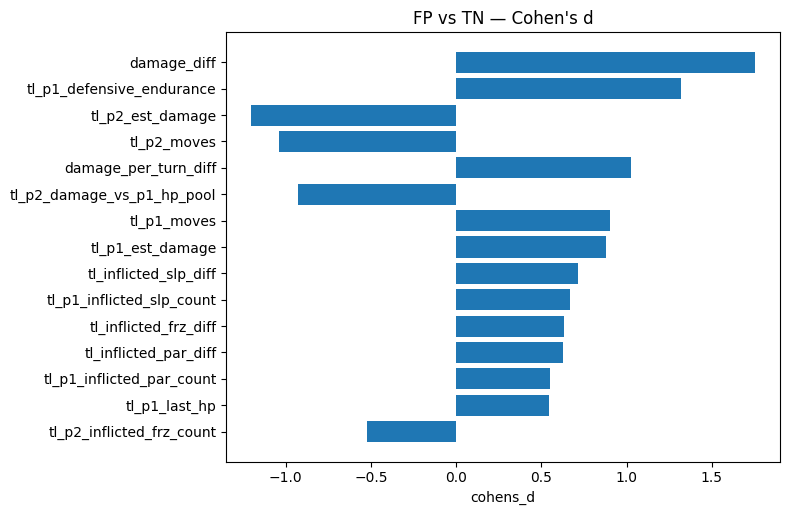

✅ Salvato 'fn_vs_tp_effects.png'


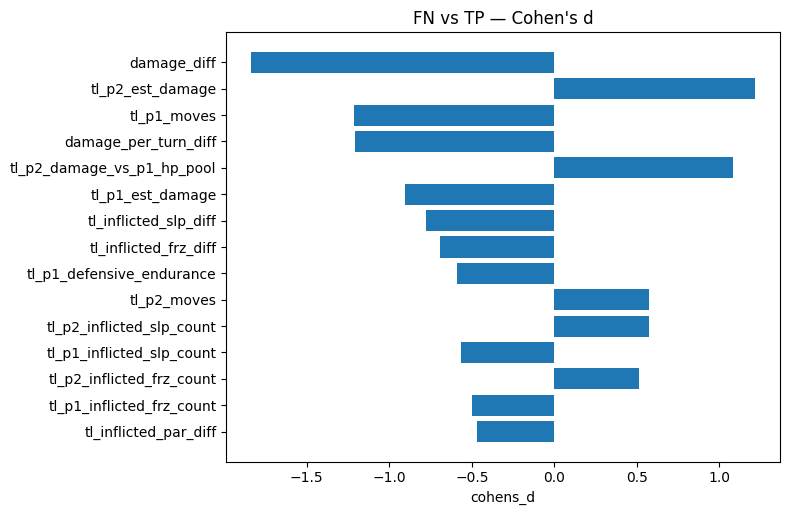

✅ Salvato 'fp_shap_diff.png'


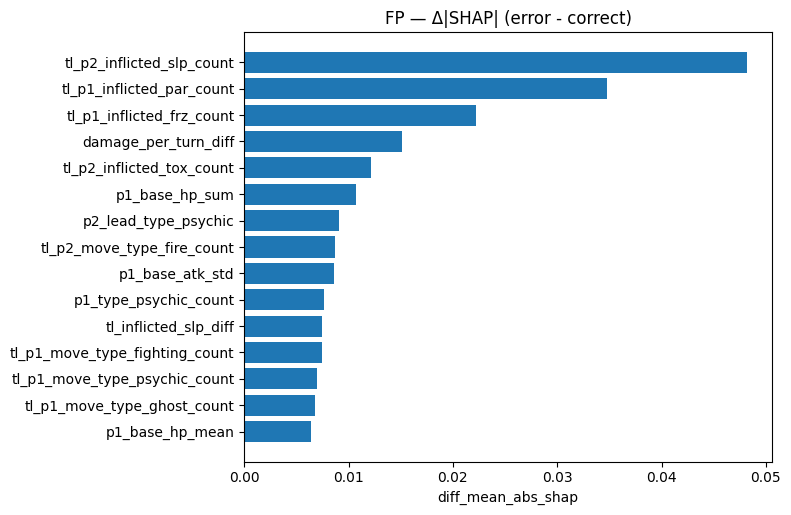

✅ Salvato 'fn_shap_diff.png'


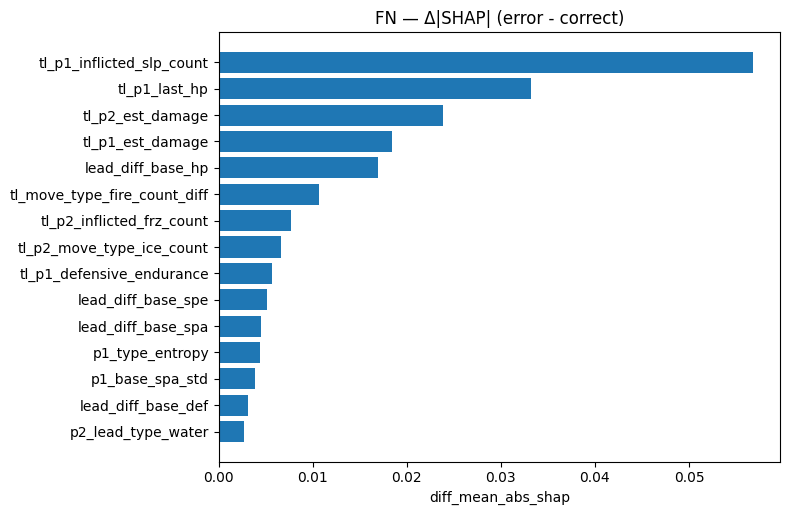


Suggerimento:
- Usa error_feature_diagnostics.csv per vedere le feature più associate a errori.
- Chiama explain_battle(<battle_id>) per vedere le top feature che hanno spinto la predizione (SHAP).


In [61]:
# Analisi delle peculiarità degli errori (FP/FN) e motivazioni con SHAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prepara il dataset holdout con feature + etichette + meta
holdout_idx = pd.Index(idx_holdout)
Xh_df = pd.DataFrame(X_holdout, index=holdout_idx, columns=FEATURES)

try:
    proba = y_hold_proba
except NameError:
    proba = final_model.predict_proba(X_holdout)[:, 1]

meta_cols = ['battle_id'] if 'battle_id' in train_df.columns else []
meta = train_df.loc[holdout_idx, meta_cols].copy() if meta_cols else pd.DataFrame(index=holdout_idx)

hold_meta = pd.DataFrame({
    'y_true': y_holdout.astype(int),
    'y_pred': y_hold_pred.astype(int),
    'proba_win': proba.astype(float)
}, index=holdout_idx)
hold_meta['error_type'] = np.where(
    (hold_meta['y_true'] == 0) & (hold_meta['y_pred'] == 1), 'FP',
    np.where((hold_meta['y_true'] == 1) & (hold_meta['y_pred'] == 0), 'FN', 'OK')
)
H = meta.join(hold_meta).join(Xh_df)

FP = H[(H.y_true==0) & (H.y_pred==1)]   # falsi Win
TN = H[(H.y_true==0) & (H.y_pred==0)]   # Loss corretti
FN = H[(H.y_true==1) & (H.y_pred==0)]   # Win perse
TP = H[(H.y_true==1) & (H.y_pred==1)]   # Win corretti

# 2) Effect size (Cohen's d) per FP vs TN e FN vs TP
def cohen_d(a, b):
    a = a.astype(float); b = b.astype(float)
    ma, mb = np.nanmean(a), np.nanmean(b)
    sa, sb = np.nanstd(a, ddof=1), np.nanstd(b, ddof=1)
    n1, n2 = len(a), len(b)
    sp = np.sqrt(((n1-1)*sa*sa + (n2-1)*sb*sb) / max(n1+n2-2, 1))
    if sp == 0:
        return 0.0
    return (ma - mb) / sp

def rank_effects(group_a, group_b, label):
    rows = []
    for f in FEATURES:
        d = cohen_d(group_a[f], group_b[f])
        rows.append({'feature': f, 'cohens_d': d, 'pair': label})
    df = pd.DataFrame(rows).sort_values('cohens_d', key=np.abs, ascending=False)
    return df

fx_fp = rank_effects(FP, TN, 'FP_vs_TN')
fx_fn = rank_effects(FN, TP, 'FN_vs_TP')
diag_df = pd.concat([fx_fp.head(50), fx_fn.head(50)], ignore_index=True)
diag_df.to_csv('error_feature_diagnostics.csv', index=False)
print("✅ Salvato 'error_feature_diagnostics.csv' (top 50 per coppia).")

# Visualizza top 15 per ciascun confronto
print('\nTop 15 feature (|d|) per FP vs TN:')
display(fx_fp.head(15))
print('\nTop 15 feature (|d|) per FN vs TP:')
display(fx_fn.head(15))

# 3) SHAP analysis: errori vs corretti
try:
    import shap
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'shap', '-q'])
    import shap

explainer = shap.TreeExplainer(final_model)
shap_vals = explainer.shap_values(X_holdout)  # shape: (n, n_features)
if isinstance(shap_vals, list):
    shap_vals = shap_vals[1]  # compat per alcuni wrapper

idx_FP = FP.index.intersection(holdout_idx)
idx_TN = TN.index.intersection(holdout_idx)
idx_FN = FN.index.intersection(holdout_idx)
idx_TP = TP.index.intersection(holdout_idx)

abs_shap = np.abs(shap_vals)
mean_abs_shap_FP = abs_shap[holdout_idx.get_indexer(idx_FP)].mean(axis=0) if len(idx_FP)>0 else np.zeros(len(FEATURES))
mean_abs_shap_TN = abs_shap[holdout_idx.get_indexer(idx_TN)].mean(axis=0) if len(idx_TN)>0 else np.zeros(len(FEATURES))
mean_abs_shap_FN = abs_shap[holdout_idx.get_indexer(idx_FN)].mean(axis=0) if len(idx_FN)>0 else np.zeros(len(FEATURES))
mean_abs_shap_TP = abs_shap[holdout_idx.get_indexer(idx_TP)].mean(axis=0) if len(idx_TP)>0 else np.zeros(len(FEATURES))

diff_FP = mean_abs_shap_FP - mean_abs_shap_TN
diff_FN = mean_abs_shap_FN - mean_abs_shap_TP

shap_df_FP = pd.DataFrame({'feature': FEATURES, 'diff_mean_abs_shap': diff_FP}).sort_values('diff_mean_abs_shap', ascending=False)
shap_df_FN = pd.DataFrame({'feature': FEATURES, 'diff_mean_abs_shap': diff_FN}).sort_values('diff_mean_abs_shap', ascending=False)

print('\nTop 15 feature SHAP (error importance - correct) per FP:')
display(shap_df_FP.head(15))
print('\nTop 15 feature SHAP (error importance - correct) per FN:')
display(shap_df_FN.head(15))

# 4) Grafici sintetici
def plot_bar_top(df, value_col, title, fname, k=15):
    top = df.head(k)
    plt.figure(figsize=(8, max(4, k*0.35)))
    plt.barh(top['feature'][::-1], top[value_col][::-1], color='tab:blue')
    plt.title(title)
    plt.xlabel(value_col)
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    print(f"✅ Salvato '{fname}'")
    plt.show()

plot_bar_top(fx_fp.assign(abs_d=np.abs(fx_fp.cohens_d)).sort_values('abs_d', ascending=False), 'cohens_d', 'FP vs TN — Cohen\'s d', 'fp_vs_tn_effects.png')
plot_bar_top(fx_fn.assign(abs_d=np.abs(fx_fn.cohens_d)).sort_values('abs_d', ascending=False), 'cohens_d', 'FN vs TP — Cohen\'s d', 'fn_vs_tp_effects.png')
plot_bar_top(shap_df_FP, 'diff_mean_abs_shap', 'FP — Δ|SHAP| (error - correct)', 'fp_shap_diff.png')
plot_bar_top(shap_df_FN, 'diff_mean_abs_shap', 'FN — Δ|SHAP| (error - correct)', 'fn_shap_diff.png')

# 5) Spiegazione di una singola partita (per battle_id)
def explain_battle(battle_id, topk=10):
    if 'battle_id' not in H.columns:
        print('battle_id non disponibile in holdout.'); return
    rows = H.index[H['battle_id'] == battle_id]
    if len(rows)==0:
        print('battle_id non trovato nello holdout.'); return
    ridx = rows[0]
    xi = Xh_df.loc[ridx].values.reshape(1,-1)
    proba_i = float(final_model.predict_proba(xi)[:,1][0])
    pred_i = int(proba_i >= (globals().get('DECISION_THRESHOLD', 0.5)))
    true_i = int(H.loc[ridx, 'y_true'])
    etype = 'FP' if (true_i==0 and pred_i==1) else ('FN' if (true_i==1 and pred_i==0) else 'OK')
    sv = explainer.shap_values(xi)
    if isinstance(sv, list):
        sv = sv[1]
    sv = sv.reshape(-1)
    contrib = pd.DataFrame({'feature': FEATURES, 'shap': sv, 'abs_shap': np.abs(sv), 'value': Xh_df.loc[ridx, FEATURES].values})
    contrib = contrib.sort_values('abs_shap', ascending=False).head(topk)
    print(f"battle_id={battle_id} | y_true={true_i} | y_pred={pred_i} | proba={proba_i:.3f} | error_type={etype}")
    display(contrib[['feature','value','shap']])

print("\nSuggerimento:")
print("- Usa error_feature_diagnostics.csv per vedere le feature più associate a errori.")
print("- Chiama explain_battle(<battle_id>) per vedere le top feature che hanno spinto la predizione (SHAP).")

In [ ]:
# === Ensemble su holdout: media di probabilità su seed diversi ===
import numpy as np

ENSEMBLE_SEEDS = [11, 22, 33, 44, 55]  # modifica per 3-5+ modelli

def fit_ensemble_predict_proba(X_tr, y_tr, X_eval, base_params, seeds):
    probs = np.zeros(X_eval.shape[0], dtype=float)
    models = []
    for s in seeds:
        params = dict(base_params)
        clf = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=int(s))
        clf.fit(X_tr, y_tr, verbose=False)
        probs += clf.predict_proba(X_eval)[:, 1]
        models.append(clf)
    probs /= max(1, len(seeds))
    return probs, models

# Allena K modelli su tutto train_val e valuta su holdout
y_hold_proba_ens, ens_models_holdout = fit_ensemble_predict_proba(
    X_train_val, y_train_val, X_holdout, best_params, ENSEMBLE_SEEDS
)
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5
y_hold_pred_ens = (y_hold_proba_ens >= THR).astype(int)
hold_acc_ens = accuracy_score(y_holdout, y_hold_pred_ens)
print(f"Ensemble seeds: {ENSEMBLE_SEEDS}")
print(f"Holdout accuracy (ensemble): {hold_acc_ens:.4f} | threshold={THR:.3f}")
print("Nota: le probabilità sono medie su K modelli per ridurre la varianza.")

In [ ]:
# === Ensemble finale su TUTTO il train e submission_ens.csv ===
X_full = train_df[FEATURES].values
y_full = train_df['player_won'].values
X_test = test_df[FEATURES].values

test_proba_ens, ens_models_full = fit_ensemble_predict_proba(
    X_full, y_full, X_test, best_params, ENSEMBLE_SEEDS
)
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5
test_pred_ens = (test_proba_ens >= THR).astype(int)
print(f"Predictions threshold used (ensemble): {THR:.3f}")

# Allinea le predizioni ensemble all'ordine e agli ID di test.jsonl
battle_ids_raw = np.array([int((r or {}).get('battle_id')) for r in test_raw], dtype=np.int64)
pred_map_ens = dict(zip(test_df['battle_id'].astype(np.int64).to_numpy(), test_pred_ens.astype(np.int64)))
player_won_ens = np.array([pred_map_ens.get(bid, 0) for bid in battle_ids_raw], dtype=np.int64)

# Costruzione submission ensemble: 2 colonne [battle_id, player_won] (no tuple)
submission_ens = pd.DataFrame({
    'battle_id': battle_ids_raw.astype(np.int64),
    'player_won': player_won_ens.astype(np.int64)
})
submission_ens = submission_ens[['battle_id', 'player_won']]

# Sanitizzazione extra su tuple/array
if submission_ens['battle_id'].apply(lambda v: isinstance(v, (tuple, list, np.ndarray))).any():
    submission_ens['battle_id'] = submission_ens['battle_id'].map(int).astype(np.int64)
if submission_ens['player_won'].apply(lambda v: isinstance(v, (tuple, list, np.ndarray))).any():
    submission_ens['player_won'] = submission_ens['player_won'].map(int).astype(np.int64)

assert submission_ens.shape[1] == 2, "La submission_ens deve avere 2 colonne"
assert list(submission_ens.columns) == ['battle_id','player_won'], "Header submission_ens errato"
assert submission_ens['battle_id'].dtype == 'int64', "battle_id deve essere int64"
assert submission_ens['player_won'].dtype == 'int64', "player_won deve essere int64"
assert submission_ens['player_won'].isin([0,1]).all(), "Valori player_won non binari"
assert submission_ens.isna().sum().sum() == 0, "NaN nella submission_ens"

submission_ens.to_csv('submission_ens.csv', index=False)

sub_check_ens = pd.read_csv('submission_ens.csv', dtype={'battle_id': np.int64, 'player_won': np.int64})
assert sub_check_ens.shape[1] == 2, "File submission_ens.csv non ha 2 colonne"
assert list(sub_check_ens.columns) == ['battle_id','player_won'], "Header submission_ens errato"
assert sub_check_ens['player_won'].isin([0,1]).all(), "Valori player_won non binari (ensemble)"

print("\nsubmission_ens.csv creata e verificata. Prime righe:")
print(sub_check_ens.head().to_string(index=False))
print("Dtypes:")
print(sub_check_ens.dtypes)
print(f"\nDistribuzione predizioni (ensemble): {np.bincount(sub_check_ens['player_won'])}")